In [2]:
import numpy as np
import matplotlib.pyplot as plt
from Cumulant4_fonction import C4_long, C4_court, Cross_time
from DoubleRigidWallOverdampedLangevin3D_cython import RigidWallOverdampedLangevin3D
from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm
# axes.xaxis.set_tick_params(direction='in', which='both')
# axes.yaxis.set_tick_params(direction='in', which='both')


mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams["lines.markeredgecolor"] = "k"
mpl.rcParams["lines.markeredgewidth"] = 1
mpl.rcParams["figure.dpi"] = 200
from matplotlib import rc

rc("font", family="serif")
rc("text", usetex=False)
rc("xtick", labelsize="medium")
rc("ytick", labelsize="medium")
rc("axes", labelsize="large")

# Model de diffusion dans un canal étroit sans potentiel

Code origine : $\mathrm{\color{red}{Cumulant4\_fonction.py}}$

Auteur : $\mathrm{\color{purple}{Élodie ~MILLAN}}$

Date : 19/11/2021


- $2H_p$ : hauteur du canal;
- $a$ : rayon de la particule;
- $V$ : potentiel où la particule est soumis
- $D_\|(z)$ : coeficient de diffusion selon l'axe parallèle aux murs 
- $D_\perp(z)$ : coeficient de diffusion selon l'axe perpendiculaire aux murs 


In [3]:
H = 1.5e-6
a = 0.5e-6
Hs = H+0.1e-6 # Hs > H
Hp = H-a
kBT = 4e-21
beta = 1/kBT

# lB = [0.1e-6, 0.2e-6, 0.5e-6]
# Nt_sub = [1, 10, 100]
# dt = [1e-5, 1e-3]

Nt = int(10000000)

Db = kBT/(6*np.pi*0.001*a)
D_para0 = (H-a)/(2*a) * Db
D_perp0 = (H-a)/(2*a) * Db


In [4]:
def Dpara(z):
    """
    D parallèle en fonction de z.
    Return: une liste de Dpara de meme taille que z.
    """
    return (D_para0*(1-(z/Hs)**2))

def Dperp(z):
    """
    D perpendiculaire en fonction de z.
    Return: une liste de Dperp de meme taille que z.
    D=0 lorsque z = +/-(H-a)
    """
    return D_perp0*(1-(z/(H-a))**2)

def V(z):
    """
    Potentiel subit par la particule en fonction de z.
    Return: une liste de V de meme taille que z.
    """
    return 0#z/(beta*lB)

def _Peq(z):
    P_eq = np.exp(-beta*V(z))
    N = quad(lambda zz: np.exp(-beta*V(zz)), -Hp, Hp)[0]
    
    if z > Hp:
        return 0
    elif z < -Hp:
        return 0
    else:
        return P_eq / N

def Peq(z):
    
    if type(z) == float:
        return _Peq(z)
    z = np.array(z)
    return np.array([_Peq(zz) for zz in z])
    
def _Pdz(dz):
    
    return 1 / (4 * Hp**2) * (2 * Hp - np.abs(dz))

def P_dz(dz):
    
    return np.array([_Pdz(i) for i in dz])

    
    


In [5]:
zz = np.linspace(-Hp, Hp, 1000)
dz = np.linspace(-2*Hp, 2*Hp, 1000)

Pdz = P_dz(dz)

In [6]:
# plt.plot(dz, Pdz)

### Théorie

In [7]:
D4, C4 = C4_long(Dpara=Dpara, Dperp=Dperp, V=V, kBT=kBT, a=-H+a, b=H-a)
A4 = C4_court(Dpara=Dpara, V=V, kBT=kBT, a=-H+a, b=H-a)

In [8]:
# c = Hp/lB
# toint = quad(lambda t: (np.cosh(t) - 1)/t, 0, 2*c)[0]
# d4 = ((5 + 4*c**2 - 5*np.cosh(2*c) + c*np.sinh(2*c) + 4*c/np.tanh(c)*toint)
#          /
#          (c**4 * np.sinh(c)**2)
#     )
# D4_theo = D_para0**2 * np.power(Hp,6)/(np.power(Hs, 4)*D_perp0)*d4
# C4_theo = "Non défini"

In [9]:
#Theorie pour tout temps
C4_tot_theo = lambda t: (2 * t * np.power(H-a,6) * np.power(D_para0,2)) / (135 * D_perp0 * np.power(Hs,4)) - (
    np.power(H-a,8) * np.power(D_para0,2)
) / (405 * np.power(D_perp0,2) * np.power(Hs,4)) * (1 - np.exp(-(6 * D_perp0 * t) / (np.power(H-a,2))))


### Simulation multipross $N_\mathrm{simu}$

In [10]:
import csv
from multiprocessing import Pool
import itertools

In [16]:
# !rm fakeDiff_TESTMAXOU.csv
Nsim = 20

tau4_simu = []
C4_simu = []

lBs = [0.1e-6, 0.2e-6, 0.5e-6]
Nt_subs = [1, 10, 100]
dts = [1e-5, 1e-3]


def compute(n, dt, lB, Nt_sub):
    datafile = 'FakeDiff_Datas/dt_{:e}_lB_{:e}_Ntsub_{:e}_.csv'.format(dt, lB, Nt_sub)
    simu = RigidWallOverdampedLangevin3D(dt=dt, Nt=Nt, a=a, H=H, Hs=Hs, lB=lB, Nt_sub=Nt_sub)
    simu.trajectory()
    taux, c4x = simu.Cumulant4("x", plot=False, output=True)
    tauy, c4y = simu.Cumulant4("y", plot=False, output=True)
    tau = (taux+tauy)/2
    c4 = (c4x+c4y)/2
    csvfile = open(datafile,'a', newline='')
    writer = csv.writer(csvfile)
    writer.writerow(c4)
    tau4_simu.append(tau)
    C4_simu.append(c4)
    
with Pool(7) as p:
    iterrable = itertools.product(np.arange(Nsim), dts, lBs, Nt_subs)
    p.starmap(compute, iterrable)

In [ ]:
metadata = {}
i=0
while i < len(datafile.split("_")[1:-1]):
    info = datafile.split("_")[1:-1]
    metadata[info[i]]= float(info[i+1])
    i+=2

In [ ]:
metadata

In [ ]:
datafile

In [27]:
lBs = [0.1e-6, 0.2e-6, 0.5e-6]
Nt_subs = [1, 10, 100]
dts = [1e-5, 1e-3]

LB = lBs[0]
Nt_sub = Nt_subs[2]
dt=dts[1]

data = np.loadtxt("fakeDiff_dt_1e-5_Nt_1e7_Ntsub_100_lB_1e-7.csv", delimiter = ",")
tt_court = np.linspace(1e-5, dt*Nt, 2000000) 
tt_long = np.linspace(1e-5, dt*Nt, 2000000) 

C4_simu = np.mean(data, axis=0)
Err_c4_simu = np.std(data, axis=0)

list_dt_c4 = np.array([], dtype=int)
for i in range(len(str(Nt)) - 3):
    # Take just 10 points by decade.
    list_dt_c4 = np.concatenate(
        (
            list_dt_c4,
            np.arange(10 ** i, 10 ** (i + 1), 10 ** i, dtype=int),
        )
    )
tau = list_dt_c4*dt*Nt_sub

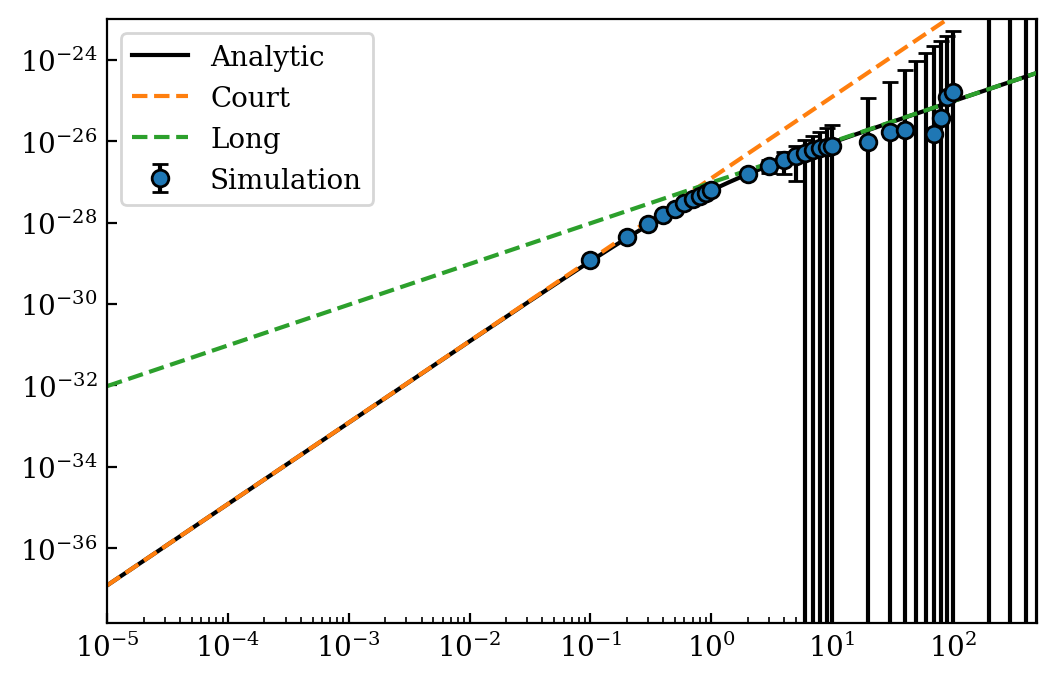

In [28]:
plt.errorbar(tau, C4_simu,yerr=Err_c4_simu, fmt="o", label=r"Simulation", ecolor = "black", capsize = 3)
plt.loglog(tt_court, C4_tot_theo(tt_court), "k", label=r"Analytic")
plt.loglog(tt_court, A4*tt_court**2, "--",label=r"Court")
plt.plot(tt_long, D4*tt_long-C4*0,"--", label=r"Long")
plt.xlim([1e-5, 5e2])
plt.ylim([None, 1e-23])
plt.legend()
plt.show()

In [ ]:
stop

 varieties## Calcul de la MSD$_\|$
On pose $H_p = H-a$
La distribution d'equilibre de la particule dans ce canal est constante car il n'y a pas de potentiel, donc :

\begin{equation} 
P_\mathrm{eq} = \frac{1}{2H_p},
\end{equation}
car $\int_{-Hp}^{+Hp} P_\mathrm{eq} \mathrm{d}z = 1$.

Donc la moyenne spatial du coeficient de diffusion $D_\|(z)$ est donnée par :
\begin{equation} 
   \langle D_\|(z) \rangle_z = \int_{-H_p}^{+H_p}P_\mathrm{eq}~D_\|(z) \mathrm{d}z = \int_{-H_p}^{+H_p} \frac{D_\|^0}{2H_p} \left( 1- \frac{z^2}{H_s^2} \right) \mathrm{d}z = \frac{D_\|^0}{2H_p} \left( 2H_p - \frac{2H_p^3}{3H_s^2} \right) = D_\|^0 \left( 1 - \frac{H_p^2}{3H_s^2} \right).
\end{equation}

Permettant d'écrire la MSD$_\|$ :

\begin{equation} 
\mathrm{MSD}_\| = 2 \langle D_\|(z) \rangle_z \tau,
\end{equation}
où $\tau$ sont les temps de déplacements.

## Calcul de la MSD$_\perp$ au temps court

De même, 
\begin{equation} 
   \langle D_\perp(z) \rangle_z = \int_{-H_p}^{+H_p}P_\mathrm{eq}~D_\perp(z) \mathrm{d}z = \int_{-H_p}^{+H_p} \frac{D_\perp^0}{2H_p} \left( 1- \frac{z^2}{H_p^2} \right) \mathrm{d}z = \frac{D_\perp^0}{2H_p} \left( 2H_p - \frac{2H_p^3}{3H_p^2} \right) = D_\perp^0 \left( 1 - \frac{1}{3} \right) = \frac{2}{3} D_\perp^0,
\end{equation}

avec :
\begin{equation} 
\mathrm{MSD}_\perp = 2 \langle D_\perp(z) \rangle_z \tau,
\end{equation}

## Calcul du plateau de la MSD$_\perp$.
Pour calculer le plateau de la MSD$z$ ($\forall \tau > \tau_\mathrm{eq}$) il faut determiner la PDF des déplacement $\Delta z = z(t+\tau) - z(t)$ :

\begin{equation}
  P(\Delta z) = \int_{-2H_p}^{+2H_p} P_\mathrm{eq}(z+ \Delta z) P_\mathrm{eq}(z) \mathrm{d}z
\end{equation}

Cependant,
\begin{equation}
P_\mathrm{eq}(z) = \left\{
    \begin{array}{ll}
         \frac{1}{2H_p} & \mbox{si } z \in [ -H_p, +H_p] \\
        0 & \mbox{sinon.}
    \end{array}
\right.
\end{equation}

et,
\begin{equation}
P_\mathrm{eq}(z+ \Delta z) = \left\{
    \begin{array}{ll}
         \frac{1}{2H_p} & \mbox{si } z \in [ -H_p - \Delta z, +H_p -\Delta z] \\
        0 & \mbox{sinon.}
    \end{array}
\right.
\end{equation}

Ce sont deux fonction créneau.

Donc, l'intégrale de ces deux fonctions est égale à leur convolution. La convolution de deux créneau donne une fonction trianglulaire:

\begin{equation}
P(\Delta z) = P_\mathrm{eq}(z+ \Delta z) * P_\mathrm{eq}(z) = \int_{-H_p}^{+H_p} P_\mathrm{eq}(z+ \Delta z) P_\mathrm{eq}(z) \mathrm{d}z = \frac{1}{4H_p^2}(2H_p - | \Delta z| ).
\end{equation}

Pour le montrer, considérons les 2 cas $\Delta z > 0$ et $\Delta z < 0$:

1. $\underline{\Delta z > 0} \Leftrightarrow \underline{\Delta z = |\Delta z|}$ :

\begin{equation}
P(\Delta z) = \int_{-H_p + \Delta z}^{+H_p} \frac{1}{4H_p^2}  \mathrm{d}z = \frac{1}{4H_p^2} \{H_p - (-H_p + \Delta z)\} = \frac{1}{4H_p^2} \{ 2H_p - \Delta z \} = \frac{1}{4H_p^2} \{ 2H_p - |\Delta z| \}.
\end{equation}

2. $\underline{\Delta z < 0} \Leftrightarrow \underline{\Delta z = - |\Delta z|}$ :

\begin{equation}
P(\Delta z) = \int_{-H_p}^{+H_p - \Delta z} \frac{1}{4H_p^2}  \mathrm{d}z = \frac{1}{4H_p^2} \{H_p + \Delta z - (-H_p) \} = \frac{1}{4H_p^2} \{ 2H_p + \Delta z \} = \frac{1}{4H_p^2} \{ 2H_p - |\Delta z| \}.
\end{equation}


Donc finalement :
\begin{equation}
P(\Delta z) = \frac{1}{4H_p^2} \{ 2H_p - |\Delta z| \}.
\end{equation}

Puis on en déduis la valeur du plateau de la MSD$z$ tel que :

\begin{equation}
\langle \Delta z^2 \rangle = \int_{-2H_p}^{+2H_p} \Delta z^2 P(\Delta z) \mathrm{d}(\Delta z) = \int_{-2H_p}^{+2H_p} \Delta z^2 \frac{1}{4H_p^2} \{ 2H_p - |\Delta z| \} \mathrm{d}(\Delta z) = \int_{-2H_p}^{+2H_p} \frac{\Delta z^2}{2H_p} \mathrm{d}(\Delta z) - \int_{-2H_p}^{+2H_p} \frac{|\Delta z| \Delta z^2}{4H_p^2} \mathrm{d}(\Delta z) = \int_{-2H_p}^{+2H_p} \frac{\Delta z^2}{2H_p} \mathrm{d}(\Delta z) - 2 \int_{0}^{+2H_p} \frac{\Delta z^3}{4H_p^2} \mathrm{d}(\Delta z).
\end{equation}
Car $\int_{-a}^{+a} |x| \mathrm{d}x = 2\int_{0}^{+a} x  \mathrm{d}x$, d'où :
\begin{equation}
\langle \Delta z^2 \rangle = \frac{2}{3} H_p ^2.
\end{equation}



In [ ]:
# ---- PLateau de la MSDz
Mean_dz2 = np.trapz(dz**2 * Pdz, dz)

#Analytique
dz2Mean_ana = 2/3*Hp**2

# plt.plot(dz/2/Hp, P_dz(dz))
# plt.xlabel(r"$\Delta z / (2H_p)$")
# plt.ylabel(r"$P(\Delta z)$")
Mean_dz2 , dz2Mean_ana

In [ ]:
Hp

In [ ]:
MSDx_simu, tau_simu = simu.MSD("x", plot=False, output=True)

In [ ]:
MSDz_simu, tauZ_simu = simu.MSD("z", plot=False, output=True)

In [ ]:
t_theo = np.linspace(dt, dt*Nt*Nt_sub, 1000)

Peq_z = lambda z: 1/(2*Hp)

# D_para_mean = D_para0 * (1 - (H-a)**2/(3*Hs**2))
D_para_mean = np.trapz(Dpara(zz)*Peq_z(zz), zz)

plt.loglog(t_theo, 2*D_para_mean*t_theo, "k-", label=r"$2 \langle D_\|(z) \rangle_z \tau$")
plt.plot(tau_simu, MSDx_simu, "o", label=r"Simulation")
plt.xlabel(r"$t~(\mathrm{s})$")
plt.ylabel(r"$\mathrm{MSD}_\|~(\mathrm{m}^2)$")
plt.legend()
plt.show()

In [ ]:
t_theo = np.linspace(1e-3, 1e4, 1000)
# D_perp_mean = D_perp0 * (1 - (H-a)**2/(3*(H-a)**2))

D_perp_mean = np.trapz(Dperp(zz)*Peq_z(zz), zz)

plt.plot(tauZ_simu, MSDz_simu, "o", label=r"Simu")
plt.loglog(t_theo, 2*D_perp_mean*t_theo, "k-", label=r"$2 \langle D_\perp(z) \rangle_z \tau$")
plt.plot(np.linspace(1e0, 1e8, 1000), np.ones(1000)*Mean_dz2, "--", label=r"$\langle \Delta z^2 \rangle$")
plt.xlabel(r"$t~(\mathrm{s})$")
plt.ylabel(r"$\mathrm{MSD}_\perp~(\mathrm{m}^2)$")
plt.legend()
plt.show()

In [ ]:
x,y  = np.histogram(simu.z, bins=30, density=True)
y = (y[1:] + y[:-1])/2 
plt.plot(y,x, "o")
zz = np.linspace(-Hp, Hp, 1000)
plt.plot(zz, np.ones(len(zz))*1/2/(H-a))

plt.ylim(0.9/2/(H-a),1.1/2/(H-a)) #+/- 10%
plt.xlabel(r"$z$")
plt.ylabel(r"$P(z)$")